# Calibration

In [42]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import sys

In [43]:
img = cv.imread('C:\\Users\\ThuyLe\\Desktop\\Camera-Calibration-Release\\Camera-Calibration-Release\\calib\\2.jpg')

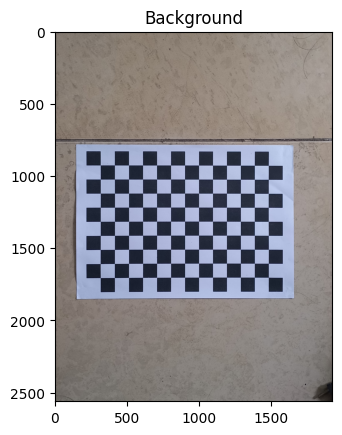

In [44]:
plt.figure()
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Background')
plt.show()

## 1. Tính toán các hệ số của máy ảnh

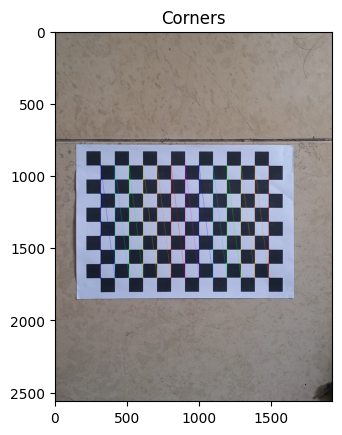

In [45]:

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# cv.TERM_CRITERIA_EPS: Kết thúc sau một số lượng lặp với sai số (epsilon) đã được đặt.
# cv.TERM_CRITERIA_MAX_ITER: Kết thúc sau một số lượng lặp tối đa.
# 30: Số lượng lặp tối đa.
# 0.001: Sai số (epsilon) cho việc dừng.
objp = np.zeros((9*13,3), np.float32)
objp[:,:2] = np.mgrid[0:8:9j,0:12:13j].T.reshape(-1,2)
size_of_chessboard_squares_mm = 17.5
objp = objp * size_of_chessboard_squares_mm

objpoints = [] # Điểm tọa độ 3D
imgpoints = [] # Điểm ảnh
images = glob.glob('C:\\Users\\ThuyLe\\Desktop\\Camera-Calibration-Release\\Camera-Calibration-Release\\calib\\2.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Tìm các góc trên chessboard
    ret, corners = cv.findChessboardCorners(gray, (9,13), None)
    
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria) # làm mịn các góc
        imgpoints.append(corners2)
        
        cv.drawChessboardCorners(img, (9,13), corners2, ret)
        #cv.drawChessboardCorners(img, (9,13), corners2, patternWasFound=True)
        plt.figure()
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title('Corners')
        plt.show()
        

In [46]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("camera matrix: ")
print(mtx)
print("distortion: ")
print(dist)
print("rvecs: ")
print(rvecs)
print("tvecs: ")
print(tvecs)

camera matrix: 
[[1.34087794e+04 0.00000000e+00 9.82726585e+02]
 [0.00000000e+00 1.35195477e+04 1.24586649e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion: 
[[-4.35541818e-01  3.97425452e+02  3.28134994e-02 -2.74690223e-02
   2.15905808e+00]]
rvecs: 
(array([[ 0.07457275],
       [-0.05923569],
       [ 1.56981495]]),)
tvecs: 
(array([[  89.6432025 ],
       [ -56.68872632],
       [2426.13722552]]),)


## 2. Tính góc quay theta từ vector quay R

In [47]:
def rodrigues_vec_to_rotation_mat(rodrigues_vec): 
    #tính góc quay theta từ vector quay R
    theta = np.linalg.norm(rodrigues_vec)
    if theta < sys.float_info.epsilon:
        rotation_mat = np.eye(3, dtype=float) # góc quay = 0 thì lấy ma trận đơn vị
    else:
        r = rodrigues_vec / theta # chuẩn hóa vecto quay R để lấy trục quay r
        I = np.eye(3, dtype=float) # ma trận đơn vị
        r_rT = np.array([
            [r[0]*r[0], r[0]*r[1], r[0]*r[2]],
            [r[1]*r[0], r[1]*r[1], r[1]*r[2]],
            [r[2]*r[0], r[2]*r[1], r[2]*r[2]]
        ]).reshape(3,3)
        r_cross = np.array([
            [0*r[0], -r[2], r[1]],
            [r[2], 0*r[0], -r[0]],
            [-r[1], r[0], 0*r[0]]
        ]).reshape(3,3)
        print(I.shape, r.shape, r_rT.shape, r_cross.shape)
        rotation_mat = np.cos(theta) * I + (1 - np.cos(theta)) * r_rT + np.sin(theta) * r_cross
    return rotation_mat

## ma trận xoay R

In [48]:
rotation = rodrigues_vec_to_rotation_mat(rvecs[0])
print('Ma trận xoay R: ')
print(rotation)

(3, 3) (3, 1) (3, 3) (3, 3)
Ma trận xoay R: 
[[ 3.47825105e-04 -9.99952356e-01  9.75525344e-03]
 [ 9.96373636e-01 -4.83478453e-04 -8.50843279e-02]
 [ 8.50849906e-02  9.74947181e-03  9.96325997e-01]]


## 3. Test cường độ màu sắc trên từng khu vực image để tìm ra khoảng của object

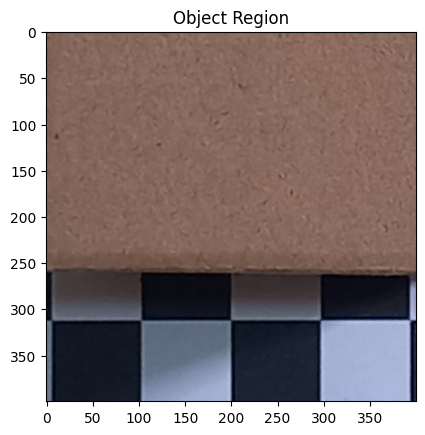

Color Matrix of the Object Region:
[[[ 80  91 119]
  [ 84  95 123]
  [ 87  98 126]
  ...
  [ 81  92 122]
  [ 90 101 131]
  [ 93 104 134]]

 [[ 78  89 117]
  [ 83  94 122]
  [ 87  98 126]
  ...
  [ 87  98 128]
  [ 92 103 133]
  [ 94 105 135]]

 [[ 79  90 118]
  [ 85  96 124]
  [ 90 101 129]
  ...
  [ 93 104 134]
  [ 96 107 137]
  [ 95 106 136]]

 ...

 [[131 113 102]
  [132 114 103]
  [134 117 108]
  ...
  [ 44  23  15]
  [ 62  42  37]
  [ 62  46  40]]

 [[130 112 101]
  [133 115 104]
  [137 120 111]
  ...
  [ 45  26  18]
  [ 63  44  39]
  [ 61  45  39]]

 [[130 112 101]
  [135 117 106]
  [139 122 113]
  ...
  [ 46  27  20]
  [ 65  46  41]
  [ 62  46  40]]]
Color Matrix of the Image:
[[[122 132 142]
  [121 131 141]
  [121 131 141]
  ...
  [147 156 169]
  [148 157 170]
  [148 157 170]]

 [[120 130 140]
  [120 130 140]
  [120 130 140]
  ...
  [147 156 169]
  [148 157 170]
  [148 157 170]]

 [[119 129 139]
  [119 129 139]
  [118 128 138]
  ...
  [147 156 169]
  [148 157 170]
  [149 158 171

In [49]:
import cv2
import numpy as np

# Đọc ảnh
image = cv2.imread('data_input\9.jpg')
x, y, w, h = 600, 1300, 400, 400 

# Trích xuất vùng quan tâm từ ma trận màu
object_region = image[y:y+h, x:x+w]
plt.imshow(cv2.cvtColor(object_region, cv2.COLOR_BGR2RGB))
plt.title('Object Region')
plt.show()
# Hiển thị ma trận màu của vùng quan tâm
print("Color Matrix of the Object Region:")
print(object_region)
# Hiển thị ma trận màu của ảnh
print("Color Matrix of the Image:")
print(image)



## Bounding Box and find Center object

Tâm của vật có tọa độ pixel: (843, 1338)


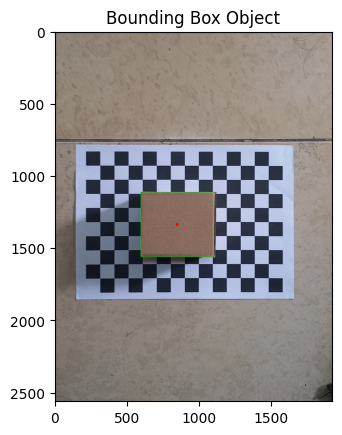

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh
image = cv2.imread('data_input\9.jpg')

# Ngưỡng màu để xác định vật trên bàn cờ, được chọn phụ thuộc vào màu của vật đã được tính toán ở trên
lower_threshold = np.array([70, 80, 110], dtype=np.uint8)
upper_threshold = np.array([100, 120, 140], dtype=np.uint8)

# Tạo mask
mask = cv2.inRange(image, lower_threshold, upper_threshold)

# Tìm contours trong mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Tìm bounding box có diện tích lớn nhất
max_area = 0
max_box = None
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
        max_area = area
        max_box = cv2.boundingRect(cnt)
center_point = []
if max_box is not None:
    x, y, w, h = max_box

    # Tính tâm của bounding box
    center_x = x + w // 2
    center_y = y + h // 2
    print(f'Tâm của vật có tọa độ pixel: ({center_x}, {center_y})')
    center_point = np.array([center_x, center_y, 1])
    # Vẽ bounding box và tâm lên ảnh
    image_with_max_bounding_box = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)
    image_with_center = cv2.circle(image_with_max_bounding_box, (center_x, center_y), 10, (0, 0, 255), -1)

    # Hiển thị ảnh với bounding box và tâm
    plt.imshow(cv2.cvtColor(image_with_center, cv2.COLOR_BGR2RGB))
    plt.title('Bounding Box Object')
    plt.show()



In [51]:
print(center_point)

[ 843 1338    1]


### convert cách 1

In [52]:

# Tính ma trận nghịch đảo của ma trận camera (Ma trận camera được chuyển đổi từ hệ tọa độ thế giới thực sang tọa độ ảnh)
# mtx là ma trận thông số của camera
inv_mtx = np.linalg.inv(mtx) # tính ma trận nghịch đảo để tìm ra ma tọa độ hệ camera
inv_R = np.linalg.inv(rotation) # ma trận nghịch đảo của ma trận R
# Convert image point to normalized coordinates
xyz_camera = inv_mtx.dot(center_point.T.reshape(3,1))  
print(xyz_camera)
# .dot: thực hiện phép nhân ma trận để tìm hệ tọa độ vật ở camera: mtx^-1 . [u v 1]^T
# biến đổi tọa độ pixcel của điểm center từ image sang tọa độ camera
# Tọa độ của vật trên hệ thực được tính thông qua công thức: Xc = R.Xw + t --> Xw = R^-1. (Xc - t)
xyz_c2 = xyz_camera - tvecs[0] #tvecs[0] là vector tịnh tieesn trong camera
xyz_real = inv_R.dot(xyz_c2) # tọa độ thực của ảnh
print('vecto tịnh tiến của camera: ', tvecs[0])
print('Ma trận nghịch đảo của ma trận thông số nội tại: ')
print(inv_mtx)
print('Ma trận nghịch đảo của ma trận xoay R: ')
print(inv_R)
print('xyz_camera', xyz_camera)
print('tvec[0]: ', tvecs[0])
print('Tọa_c2: ', xyz_c2)
print("Real-world coordinates (x, y, z=3):", xyz_real)

[[-0.01042053]
 [ 0.00681484]
 [ 1.        ]]
vecto tịnh tiến của camera:  [[  89.6432025 ]
 [ -56.68872632]
 [2426.13722552]]
Ma trận nghịch đảo của ma trận thông số nội tại: 
[[ 7.45780035e-05  0.00000000e+00 -7.32897867e-02]
 [ 0.00000000e+00  7.39669714e-05 -9.21529707e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Ma trận nghịch đảo của ma trận xoay R: 
[[ 3.47825105e-04  9.96373636e-01  8.50849906e-02]
 [-9.99952356e-01 -4.83478453e-04  9.74947181e-03]
 [ 9.75525344e-03 -8.50843279e-02  9.96325997e-01]]
xyz_camera [[-0.01042053]
 [ 0.00681484]
 [ 1.        ]]
tvec[0]:  [[  89.6432025 ]
 [ -56.68872632]
 [2426.13722552]]
Tọa_c2:  [[  -89.65362303]
 [   56.69554116]
 [-2425.13722552]]
Real-world coordinates (x, y, z=3): [[ -149.88401926]
 [   65.97813347]
 [-2421.92575976]]


### Convert cách 2 (ứng dụng đc cho trường hợp ngược lại)

In [53]:
# # mtx là ma trận K, giờ cần tìm M_int  bằng cash thêm một cột 0
# new_col = np.array([0, 0, 0])
# M_int = np.hstack((mtx, new_col.reshape(-1,1)))
# print('Ma trận thông số nội tại sau khi được đồng nhất: ')
# print(M_int)
# # Muốn tìm được Xc thì tính theo công thức [Xc | 1] = M_int ^ -1 .dot (center_point)
# M_int_inv = np.linalg.inv(M_int)
# print(M_int_inv)
M_ext = np.hstack((rotation, tvecs[0].reshape(-1,1)))
new_row = np.array([0, 0, 0, 1])
M_ext = np.vstack((M_ext, new_row))
print('Ma trận ngoài camera nhưng được đồng nhất: ')
print(M_ext)

Ma trận ngoài camera nhưng được đồng nhất: 
[[ 3.47825105e-04 -9.99952356e-01  9.75525344e-03  8.96432025e+01]
 [ 9.96373636e-01 -4.83478453e-04 -8.50843279e-02 -5.66887263e+01]
 [ 8.50849906e-02  9.74947181e-03  9.96325997e-01  2.42613723e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [54]:
# tính Xw = M_ext^-1.dot(X_camera)
Rotation_convert = np.linalg.inv(M_ext) 
print(Rotation_convert.shape)
new_row_1 = np.array([1])
xyz_camera_new = np.vstack((xyz_camera, new_row_1)) # đồngg nhất
print(xyz_camera_new)
X_world = Rotation_convert.dot(xyz_camera_new)
print('Ma trận tọa độ thực của vật: ')
print(X_world)

(4, 4)
[[-0.01042053]
 [ 0.00681484]
 [ 1.        ]
 [ 1.        ]]
Ma trận tọa độ thực của vật: 
[[-1.49884019e+02]
 [ 6.59781335e+01]
 [-2.42192576e+03]
 [ 1.00000000e+00]]


In [55]:
row_to_remove = 3
object_real = np.delete(X_world, row_to_remove, axis=0)
#object_real /= object_real[2,0]

print(object_real)

[[ -149.88401926]
 [   65.97813347]
 [-2421.92575976]]


## Lưu Ma trận nội và ngoại vi của camera

In [56]:
import numpy as np
mtx_matrix = mtx
file_path = './output/mtx.npy'
np.save(file_path, mtx_matrix)
print(f"Ma trận đã được lưu vào {file_path}")

Ma trận đã được lưu vào ./output/mtx.npy


### Intrinsic Matrix K

In [61]:
import numpy as np
file_path = './output/mtx.npy'
extrinsic_params = np.load(file_path)
print("mtx :")
print(extrinsic_params)


mtx :
[[1.34087794e+04 0.00000000e+00 9.82726585e+02]
 [0.00000000e+00 1.35195477e+04 1.24586649e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Extrinsic Matric R|t

In [58]:
import numpy as np
M_ext_matrix = np.hstack((rotation, tvecs[0].reshape(-1,1)))
M_ext_matrix = M_ext_matrix
file_path = './output/M_ext.npy'
np.save(file_path, M_ext_matrix)
print(f"Ma trận đã được lưu vào {file_path}")


Ma trận đã được lưu vào ./output/M_ext.npy


In [59]:
import numpy as np
file_path = './output/M_ext.npy'
extrinsic_params = np.load(file_path)
print("Ma trận ngoài camera")
print(extrinsic_params)


Ma trận ngoài camera
[[ 3.47825105e-04 -9.99952356e-01  9.75525344e-03  8.96432025e+01]
 [ 9.96373636e-01 -4.83478453e-04 -8.50843279e-02 -5.66887263e+01]
 [ 8.50849906e-02  9.74947181e-03  9.96325997e-01  2.42613723e+03]]
